## ECG peak detectors

In [2]:
from ecgdetectors import Detectors
detectors = Detectors(100)

In [3]:
import numpy as np

def read_numpy_array_from_file(file_path):
    try:
        with open(file_path, 'r') as file:
            data = []
            for line in file:
                if not line.startswith('#'):
                    values = line.split()
                    data.append(float(values[-1]))  # Append the last value
            return np.array(data)
    except Exception as e:
        print(f"Error reading the numpy array from the file: {e}")
        return None

# Example usage
# file_path = r"C:\Users\fred\Documents\OpenSignals (r)evolution\files\aa_bitalino_100hz.txt"  # Use raw string to avoid unicode error
file_path = r"C:\Users\fred\Downloads\ECG_record.txt"
ecg_reading = read_numpy_array_from_file(file_path)
print(ecg_reading)


[5824. 5912. 5940. ... 6274. 7166. 6246.]


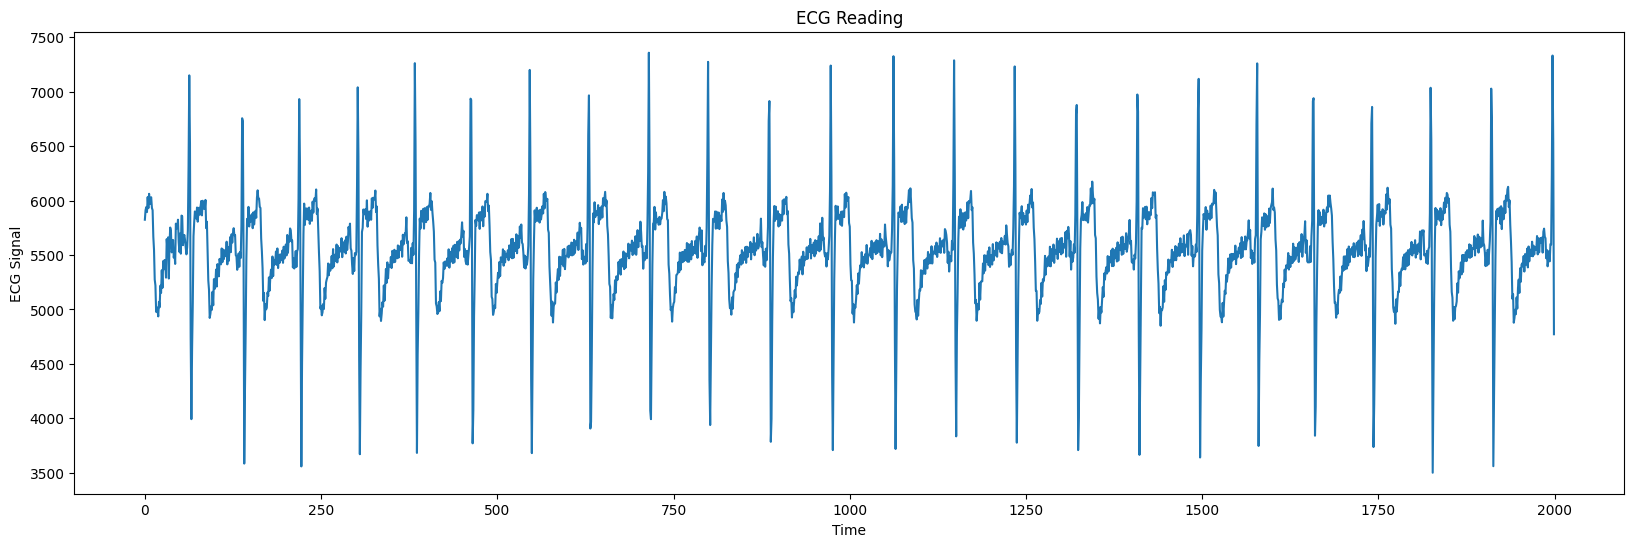

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))  # Set the figure size to be more wide
plt.plot(ecg_reading[:2000])
plt.title('ECG Reading')
plt.xlabel('Time')
plt.ylabel('ECG Signal')
plt.show()

In [8]:

def plot_peaks(peaks, ecg_array):
    plt.figure(figsize=(20, 6))  # Set the figure size to be more wide
    plt.plot(ecg_array)
    plt.title('ECG Reading')
    plt.xlabel('Time')
    plt.ylabel('ECG Signal')

    for index in peaks:
        plt.plot(index, ecg_array[index], 'ro')  # Plot red point at each specified index

    plt.show()


def plot_peaks_w_predicted(peaks, predicted, ecg_array):
    plt.figure(figsize=(20, 6))  # Set the figure size to be more wide
    plt.plot(ecg_array, label='ECG Signal')
    plt.title('ECG Reading')
    plt.xlabel('Time')
    plt.ylabel('ECG Signal')

    # Plot red points for detected peaks
    plt.plot(peaks, [ecg_array[index] for index in peaks], 'ro', label='Detected')  

    # Plot green points for predicted peaks
    plt.plot(predicted, [ecg_array[index] for index in predicted], 'go', label='Predicted')  

    plt.axvline(x=len(ecg_array) - 100, color='k', linestyle='--')  # Add a dotted vertical line at index = len(ecg_array) - 100

    plt.legend()  # Display the legend
    plt.show()


def plot_ecg_difference(ecg_array):
    plt.figure(figsize=(20, 6))  # Set the figure size to be more wide
    ecg_diff = np.diff(ecg_array, prepend=ecg_array[0])  # Calculate the difference between each reading and its predecessor
    plt.plot(ecg_diff)
    plt.title('ECG Reading Difference')
    plt.xlabel('Time')
    plt.ylabel('Difference in ECG Signal')
    plt.show()


In [11]:
import numpy as np
from scipy.signal import butter, lfilter

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def apply_filters(ecg_reading, low_cutoff, high_cutoff, fs, order=5):
    b_low, a_low = butter_lowpass(low_cutoff, fs, order=order)
    y_low = lfilter(b_low, a_low, ecg_reading)
    b_high, a_high = butter_highpass(high_cutoff, fs, order=order)
    y_high = lfilter(b_high, a_high, y_low)
    return y_high


In [36]:
filtered_ecg = apply_filters(ecg_reading[:100], low_cutoff=1, high_cutoff=1, fs=120, order=6)

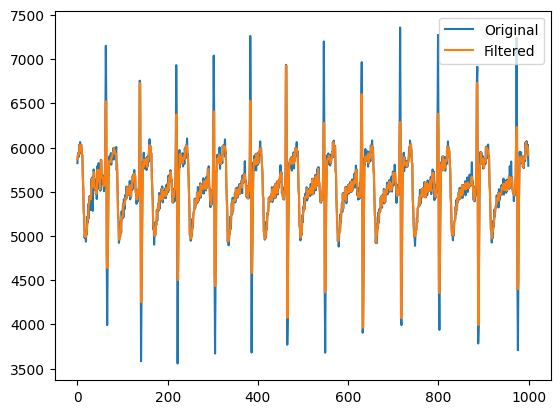

In [39]:
import numpy as np
def median_filter(data, window_size):
    filtered_data = np.zeros(len(data))
    for i in range(len(data)):
        start = max(0, i - window_size//2)
        end = min(len(data), i + window_size//2 + 1)
        window = data[start:end]
        filtered_data[i] = np.median(window)
    return filtered_data

ecg_signal = ecg_reading[:1000]
filtered_signal = median_filter(ecg_signal, 3)
# Plot original and filtered signals
import matplotlib.pyplot as plt
plt.plot(ecg_signal, label='Original')
plt.plot(filtered_signal, label='Filtered')
plt.legend()
plt.show()

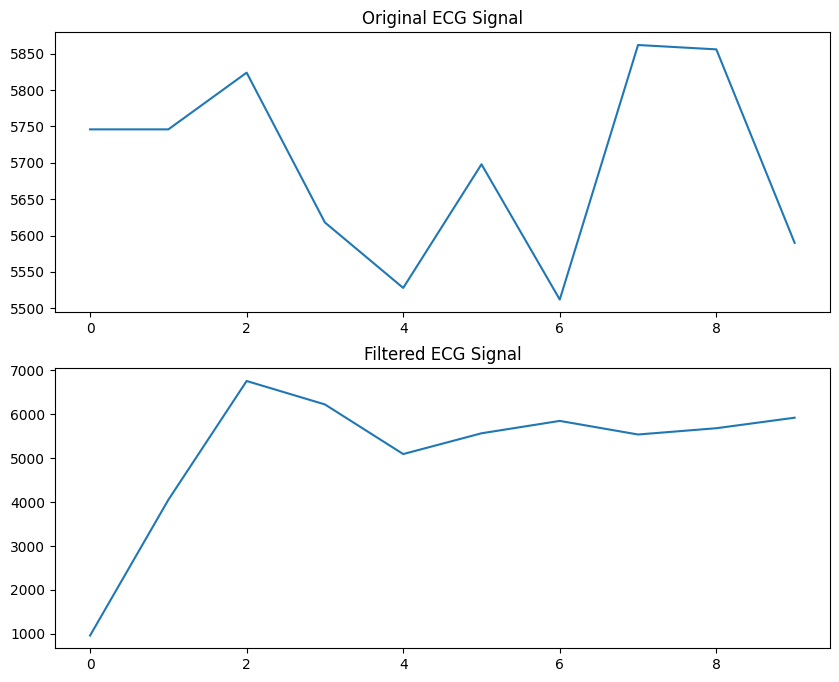

In [45]:
import numpy as np
from scipy.signal import butter, lfilter
# Cutoff frequency (in Hz)
cutoff = 30
# Order of the filter
order = 4
# Sampling frequency of the ECG signal (in Hz)
fs = 100
# Low-pass filter
b, a = butter(order, cutoff/(fs/2), btype='low')
# ECG signal data
ecg_signal =ecg_reading[45:55]
# Apply the filter
ecg_filtered = lfilter(b, a, ecg_signal)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# Plot the original signal
axs[0].plot(ecg_signal)
axs[0].set_title('Original ECG Signal')
# Plot the filtered signal
axs[1].plot(ecg_filtered)
axs[1].set_title('Filtered ECG Signal')
plt.show()

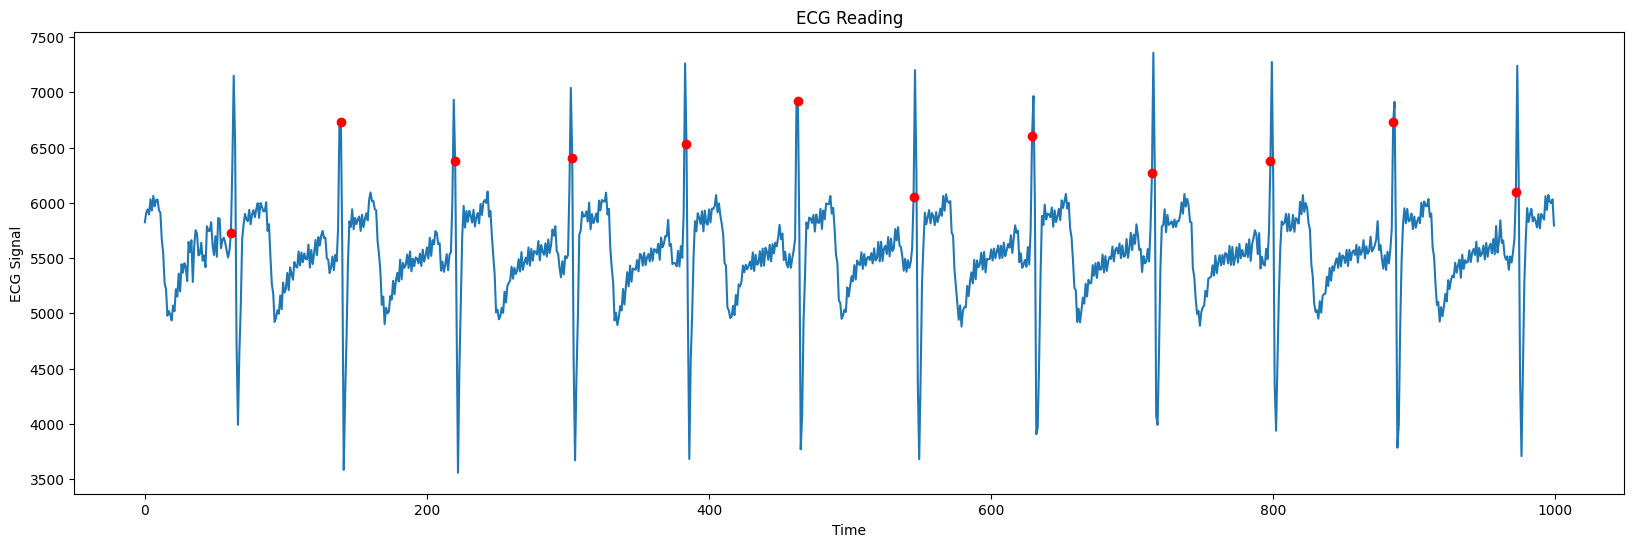

In [20]:
r_peaks = detectors.christov_detector(ecg_reading[:1000])

plot_peaks(r_peaks, ecg_reading[:1000])


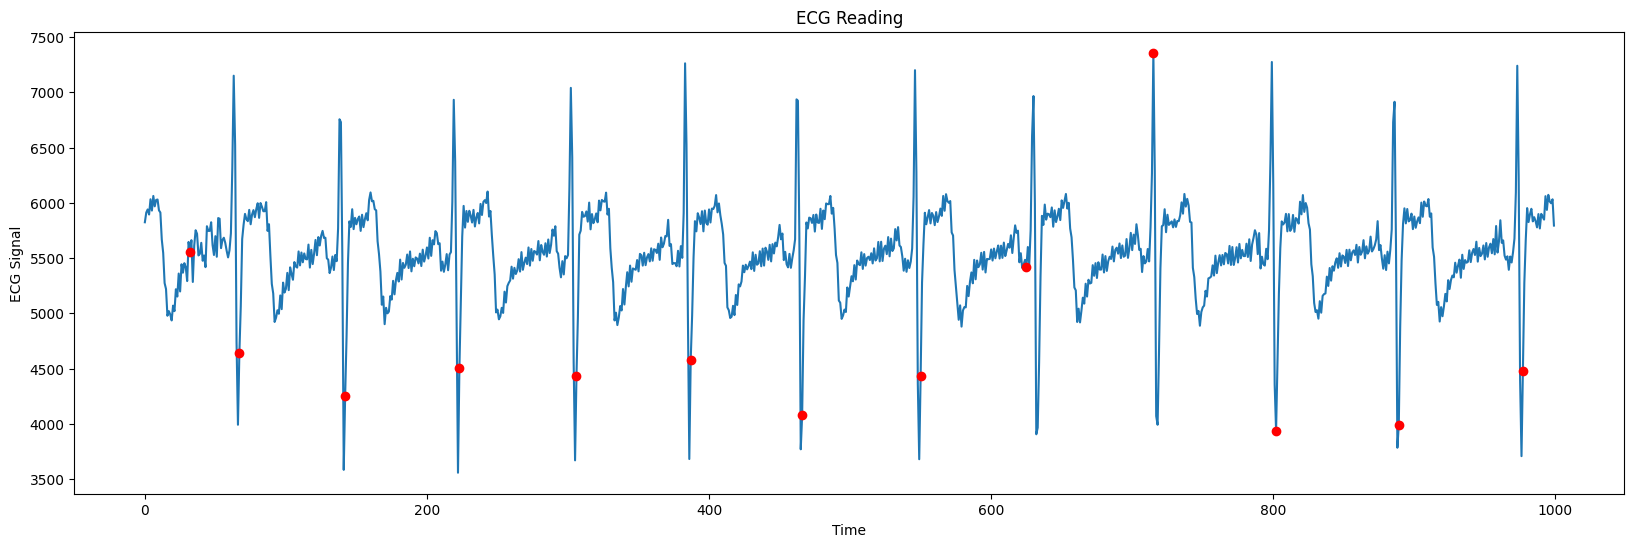

In [7]:

r_peaks = detectors.swt_detector(ecg_reading[:1000])

plot_peaks(r_peaks, ecg_reading[:1000])

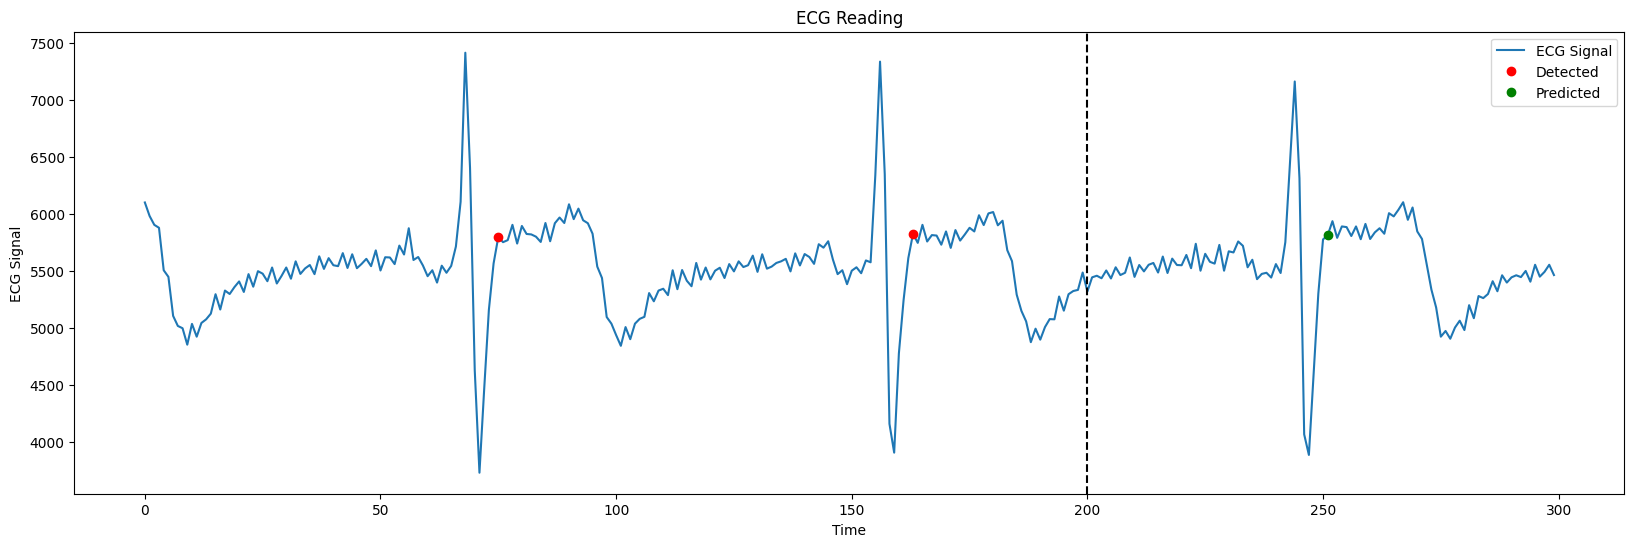

Mean difference :  88
[75, 163]
[251]


In [48]:
import random

window_size = 300

sample_index = random.randint(0, len(ecg_reading) - window_size)
data_sample = ecg_reading[sample_index:sample_index + window_size]

r_peaks = detectors.two_average_detector(data_sample[:-100])

try:
    delta_hat = int(np.mean(np.diff(r_peaks)))
except:
    pass
delta_pred = delta_hat
predicted_peaks = []

while r_peaks[-1] + delta_pred < len(data_sample) + 4:
    predicted_peaks.append(r_peaks[-1] + delta_pred)
    delta_pred = delta_pred + delta_hat

plot_peaks_w_predicted(r_peaks, predicted_peaks, data_sample)
print('Mean difference : ', delta_hat)
print(r_peaks)
print(predicted_peaks)


In [144]:
import numpy as np
import matplotlib.pyplot as plt

def real_time_processing(ecg_signal, n=30, threshold=-0.15):
    processed_signal = [0] * len(ecg_signal)
    under_threshold_indices = []
    sum_past_n = 0
    for i in range(1, len(ecg_signal)):
        if i <= n:
            mean_past_n = sum_past_n / i
            sum_past_n += ecg_signal[i-1]
        else:
            mean_past_n = sum_past_n / n
            sum_past_n += ecg_signal[i-1] - ecg_signal[0]
        
        signal_diff = ecg_signal[i] - ecg_signal[i-1]
        processed_value = signal_diff / mean_past_n if mean_past_n != 0 else 0
        processed_signal[i] = processed_value
        
        if processed_value < threshold:
            under_threshold_indices.append(i)
    
    return processed_signal, under_threshold_indices



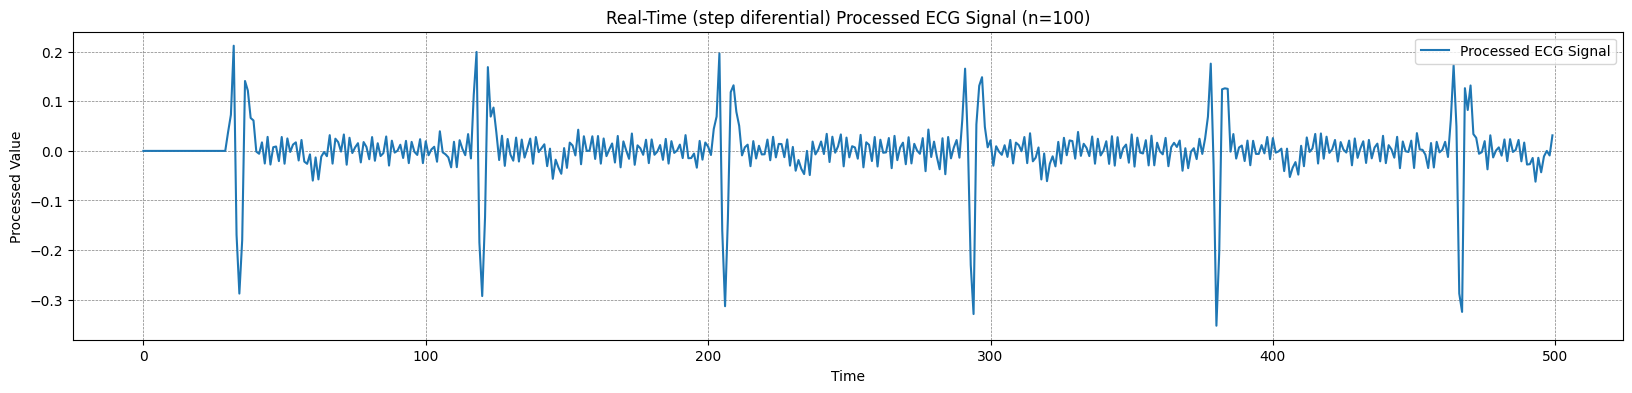

In [151]:
def moving_average_detection(ecg_signal, past_signals, past_mean_sum, n=30, threshold=-0.25):
    """
    Analyze ECG signal to detect heart beat by looking at the pondered signal diferential.

    This function calculates a processed value by comparing the current ECG signal data 
    point to the moving average of the last `n` data points in the past_signals list. 
    The moving average is adjusted dynamically with each new data point. 
    A processed value is deemed significant and indicative of a potential heart event 
    if it is below a predefined `threshold`.
    
    The algorithm is complexity O(1)  :)

    Args:
    ecg_signal (float): The current ECG signal data point.
    past_signals (list of float): A historical list of ECG signal data points.
    past_mean_sum (float): The cumulative sum of the last `n` ECG signals, used to compute the moving average efficiently.
    n (int): The number of data points to consider in the moving average.
    threshold (float): The critical value below which a signal is considered significantly deviant.

    Returns:
    float: The normalized deviation of the current signal from the moving average.
    bool: A flag indicating whether the deviation is significant (True if below the threshold).
    """
    
    if len(past_signals) < n:
        past_mean_sum += ecg_signal
        past_signals.append(ecg_signal)
        return 0, False, past_signals, past_mean_sum  # Not enough data to process

    # Update the list of past signals
    past_signals.append(ecg_signal)

    # Update the moving average sum in O(1) time complexity
    mean_past_n = float(past_mean_sum / n)
    past_mean_sum = past_mean_sum - past_signals[0] + past_signals[-1]

    if len(past_signals) > n:
        past_signals.pop(0)

    # Calculate the difference from the last signal
    signal_diff = ecg_signal - past_signals[-2]
    processed_value = float(signal_diff / mean_past_n) if mean_past_n != 0 else 0

    # Check if the processed value is below the threshold
    is_heart_beat = processed_value < threshold

    return processed_value, is_heart_beat, past_signals, past_mean_sum


window_size = 500

# sample_index = random.randint(0, len(ecg_reading) - window_size)
data_sample = ecg_reading[sample_index:sample_index + window_size]

# Assuming ecg_reading is defined and loaded with ECG data
ecg_signals = data_sample

# variables for processing algorithm
past_signals = []
past_mean_sum = 0
ignore_window_len = 15
ignore_counter = 0
processed_signals = []

# Assuming ecg_signals is a list of ECG signal data points
for ecg_signal in ecg_signals:
    processed_pot_val, is_heart_beat, past_signals, past_mean_sum  = moving_average_detection(ecg_signal, past_signals, past_mean_sum, n=30, threshold=-0.25)
    processed_signals.append(processed_pot_val)
    if (is_heart_beat and ignore_counter == 0):
        ignore_counter = ignore_window_len # reinitialize counter
    else:
        if ignore_counter > 0:
            ignore_counter = ignore_counter - 1 # reduce counter

# Plotting the processed signal
plt.figure(figsize=(20, 4))
plt.plot(processed_signals, label='Processed ECG Signal')
# for idx in under_threshold_indices:
#     plt.plot(idx, processed_ecg_signal[idx], 'ro', label='Detected' if idx == under_threshold_indices[0] else "")  # 'ro' for red dot, label only the first occurrence
plt.title('Real-Time (step diferential) Processed ECG Signal (n=100)')
plt.xlabel('Time')
plt.ylabel('Processed Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # Adding horizontal light gray grid lines
plt.legend()
plt.show()

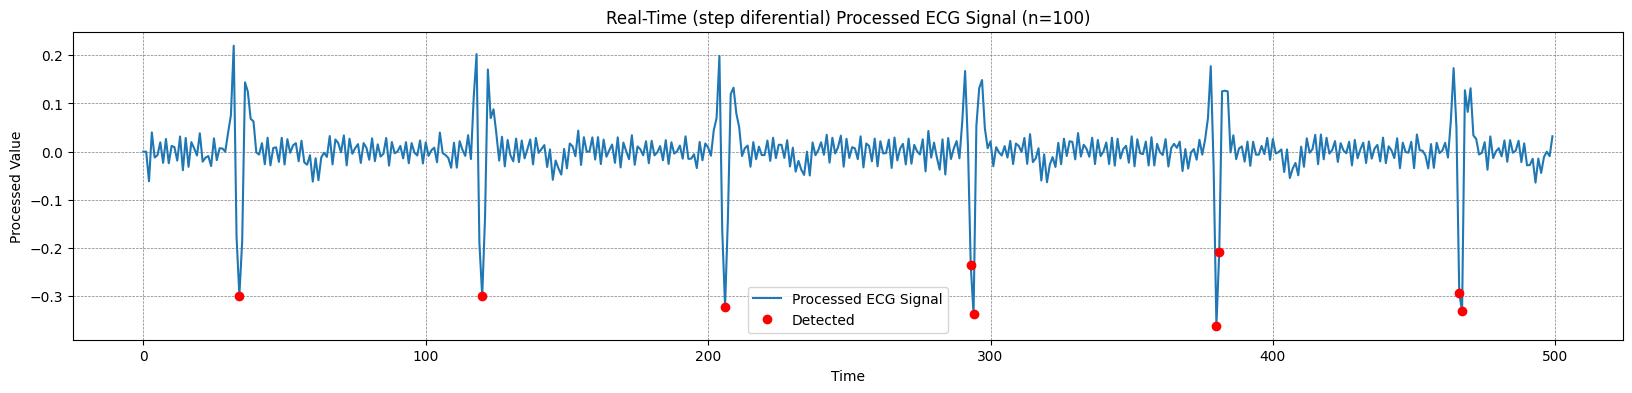

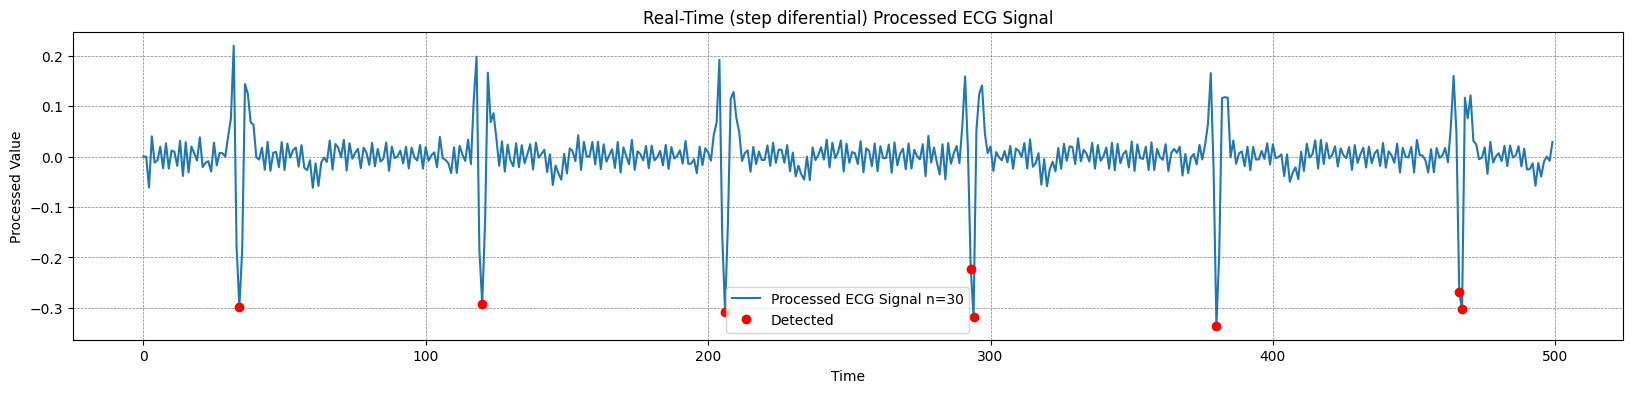

In [146]:
window_size = 500

# sample_index = random.randint(0, len(ecg_reading) - window_size)
data_sample = ecg_reading[sample_index:sample_index + window_size]

# Assuming ecg_reading is defined and loaded with ECG data
ecg_signal = data_sample
processed_ecg_signal, under_threshold_indices = real_time_processing(ecg_signal, n=400, threshold=-0.2)

# Plotting the processed signal
plt.figure(figsize=(20, 4))
plt.plot(processed_ecg_signal, label='Processed ECG Signal')
for idx in under_threshold_indices:
    plt.plot(idx, processed_ecg_signal[idx], 'ro', label='Detected' if idx == under_threshold_indices[0] else "")  # 'ro' for red dot, label only the first occurrence
plt.title('Real-Time (step diferential) Processed ECG Signal (n=100)')
plt.xlabel('Time')
plt.ylabel('Processed Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # Adding horizontal light gray grid lines
plt.legend()
plt.show()

processed_ecg_signal, under_threshold_indices = real_time_processing(ecg_signal, n=60, threshold=-0.2)

# Plotting the processed signal
plt.figure(figsize=(20, 4))
plt.plot(processed_ecg_signal, label='Processed ECG Signal n=30')
for idx in under_threshold_indices:
    plt.plot(idx, processed_ecg_signal[idx], 'ro', label='Detected' if idx == under_threshold_indices[0] else "")  # 'ro' for red dot, label only the first occurrence
plt.title('Real-Time (step diferential) Processed ECG Signal')
plt.xlabel('Time')
plt.ylabel('Processed Value')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')  # Adding horizontal light gray grid lines
plt.legend()
plt.show()

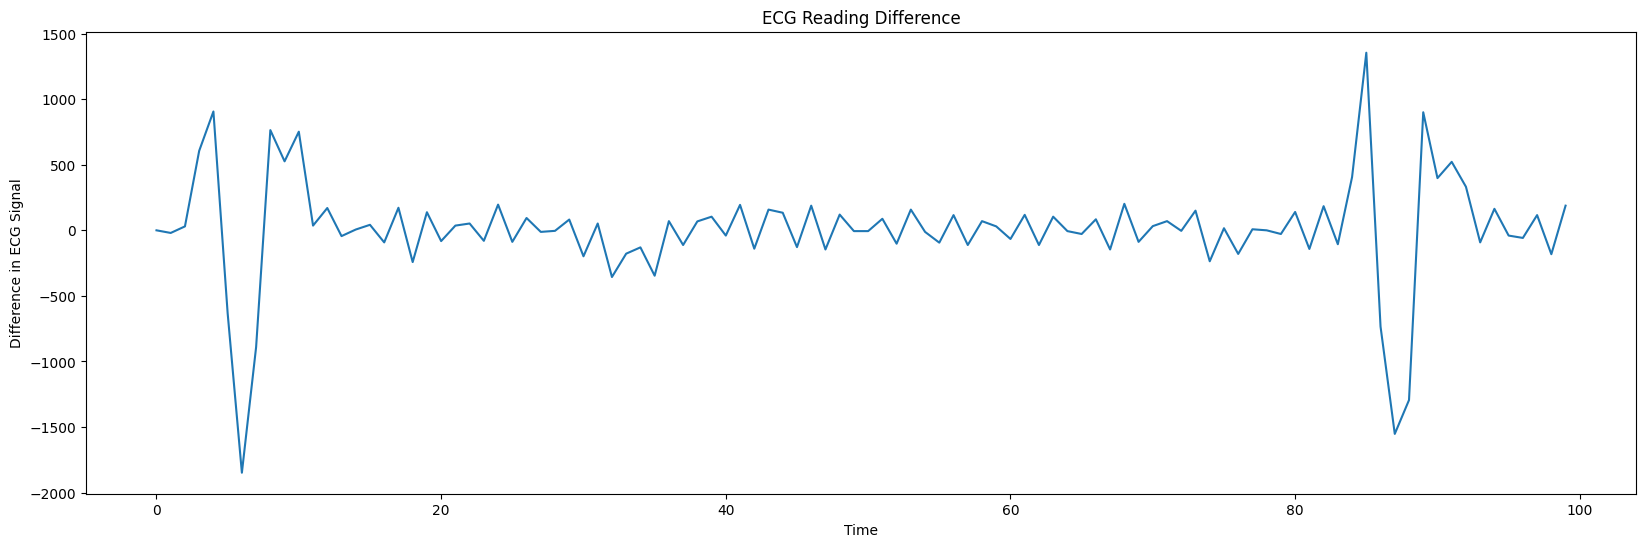

In [56]:

awindow_size = 100

sample_index = random.randint(0, len(ecg_reading) - window_size)
data_sample = ecg_reading[sample_index:sample_index + window_size]


plot_ecg_difference(data_sample)

## ECG filters

In [29]:
sample_freq = 96
high_ctf = 0.5
low_ctf = 2
line_power = 60
order = 5

data=ecg_reading[:1024]

In [32]:
from scipy import signal
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
import matplotlib.pyplot as plt


#High pass filter - this filter cutoff all values that are higher then fixed filter value

def highpass_btr(cutoff, sample_freq, order=5):
    nyquist = 0.5*sample_freq #calculate Nyquista frequency
    normal_ctf = cutoff/nyquist
    f, m = butter(order, normal_ctf, btype='high', analog=False, output='ba')

    return f, m

def high_pass(sample_data, sample_freq, order=5):
    f,m = highpass_btr(high_ctf, fs, order=order)
    x = lfilter(f,m,sample_data)

    return a



#Bandstop filter (also know as notch filter) - rejects or blocks the transmission of frequencies 
# within a specific frequency range 
# and allows frequencies outside that range.
def bandstop_filter(cutoff, dq):
    nyquist = 0.5 * sample_freq
    frequency = cutoff/nyquist

    print(frequency)
    print(nyquist)
    f, m = iirnotch(0.9, dq)

    return f, m



def bandstop(sample_data, line_power, dq):
    b,a = bandstop_filter(line_power,dq)
    z = lfilter(f,m,sample_data)
    return b


#Low pass filter - this filter cutoff all values that are lowe then fixed filter value
def lowpass_btr(cutoff, sample_freq, order=5):
    nyquist = 0.5*sample_freq
    normal_ctf = cutoff/nyquist
    f, m = butter(order, normal_ctf, btype='low', analog=False, output='ba')

    return f, m


def low_pass(sample_data, sample_freq, order=5):
    f, m = lowpass_btr(low_ctf, sample_freq, order=order)
    y = lfilter(f,m,data)

    return c


#All filters in one method


def filter_all(sample_data, sample_freq, order=5):
    f, m = highpass_btr(high_ctf, sample_freq, order=order)
    a = lfilter(f, m, data)
    x, z = lowpass_btr(low_ctf, sample_freq, order = order)
    b = lfilter(x, z, a)
    l, k = bandstop_filter(line_power, 30)
    c = lfilter(l, k, b)

    return z

1.25
48.0


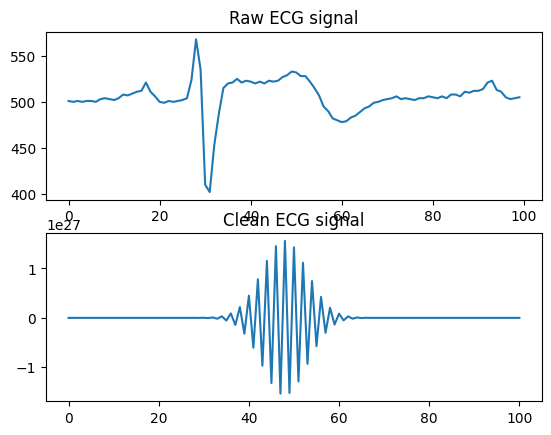

In [37]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(1)
x1 = plt.subplot(211)
plt.plot(ecg_reading[:100])
x1.set_title("Raw ECG signal")

filtered_signal = filter_all(data, sample_freq, 100)
x2 = plt.subplot(212)
plt.plot(filtered_signal)
x2.set_title("Clean ECG signal")
plt.show()